In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

> Major point is the backpropagation of grads. Starting [here](https://youtu.be/VMj-3S1tku0?t=4142) in the video.

In [54]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        _backward=None for leafs
        """
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            """how the out.grad propagate to its children's grad."""
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            """how the out.grad propagate to its children's grad."""
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [55]:
a = Value(2.0, label='a')
b = Value(0.0, label='b')
c = Value(-3.0, label='c')
d = Value(1.0, label='d')

bs = Value(6.8813735870195432, label='bs') # bias
ac = a*c; ac.label = 'ac'
bd = b*d; bd.label = 'bd'
acbd = ac + bd; acbd.label = 'ac+bd'
n = acbd + bs; n.label = 'n'
o = n.tanh(); o.label = 'o'

# L.grad = 1.0
# d._backward()

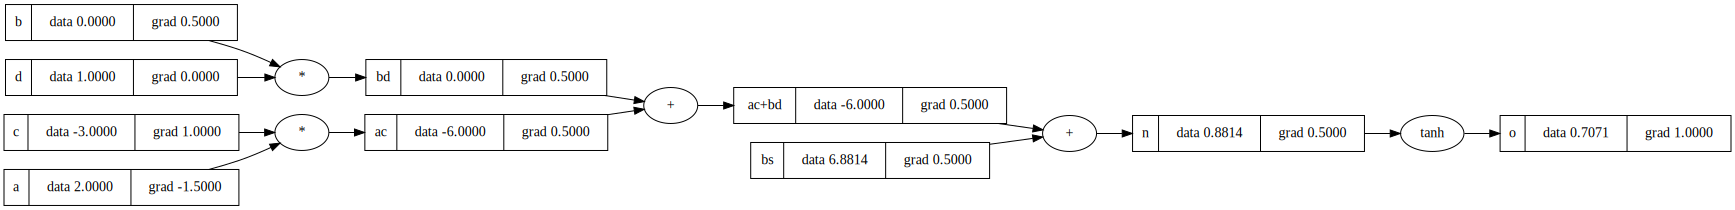

In [58]:
draw_dot(o)

In [57]:
o.backward()